In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import cv2

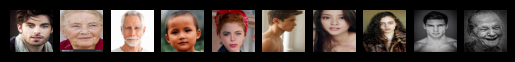

In [81]:
import matplotlib.pyplot as plt
import os

datapath = './../data/faces/'

# read some images, and display them
n = 2000
images = []
images_hls = []
# os walk
for root, dirs, files in os.walk(datapath):
    for file in files:
        # if file.endswith('.jpg'):
        img = cv2.imread(os.path.join(root, file))
        img = cv2.resize(img, (128, 128))
        
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        images_hls.append(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
        if len(images) >= n:
            break

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()

In [3]:
print('images shape:', images[0].shape)

images shape: (128, 128, 3)


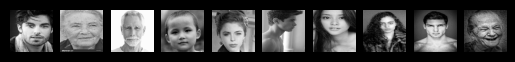

In [4]:
def hls_to_gray(img_hls):
    return img_hls[:, :, 1]

# show some images gray

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(hls_to_gray(images_hls[i]), cmap='gray')
    plt.axis('off')

In [5]:
print(images_hls[0])

[[[  0  12 127]
  [  0  12 127]
  [  0  12 127]
  ...
  [172  31  16]
  [172  27  19]
  [  0  19   0]]

 [[  0  12 127]
  [  0  12 127]
  [  0  12 127]
  ...
  [172  28  18]
  [172  28  18]
  [  0  22   0]]

 [[  0  12 127]
  [  0  12 127]
  [  0  14 109]
  ...
  [172  18  28]
  [172  15  34]
  [  0  15   0]]

 ...

 [[  0   3   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 82 133   8]
  [ 78 144  11]
  [ 96 136  11]]

 [[  0   8   0]
  [  0   6   0]
  [  0   6   0]
  ...
  [ 80 146  10]
  [ 81 142  11]
  [ 96 141  11]]

 [[  0   3   0]
  [  0   1   0]
  [  0   4   0]
  ...
  [ 80 147  11]
  [ 79 142  12]
  [ 96 135  11]]]


In [6]:
def add_hs(img_l, h, s):
    res = np.zeros((img_l.shape[0], img_l.shape[1], 3), dtype=np.uint8)
    res[:, :, 0] = h
    res[:, :, 1] = img_l
    res[:, :, 2] = s
    return res

def hue(img_hls):
    return img_hls[:, :, 0]

def saturation(img_hls):
    return img_hls[:, :, 2]

def lightness(img_hls):
    return img_hls[:, :, 1]

def hls_to_rgb(img_hls):
    return cv2.cvtColor(img_hls, cv2.COLOR_HLS2RGB)

(128, 128, 3)


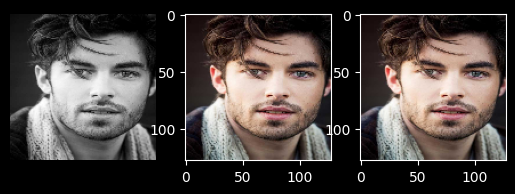

In [7]:
img = images_hls[0]
img_l = img.copy()
img_l = hls_to_gray(img_l)
img_reconstructed = add_hs(img_l, img[:, :, 0], img[:, :, 2])

# print(img_reconstructed)
print(img_reconstructed.shape)

plt.subplot(1, 3, 1)
plt.imshow(img_l, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(hls_to_rgb(img_reconstructed), cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(images[0])


In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*16*16, 16*16*16),
    nn.ReLU(),
    nn.Unflatten(1, (16, 16, 16)),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(16, 2, 3, padding=1),
    nn.Sigmoid()
)
# in -> light
# out -> hue, saturation

images_hls = np.array(images_hls)
# print(images_hls.shape)
X = [hls_to_gray(img) for img in images_hls]
X = np.array(X)
X = X / 255
y = images_hls[:, :, :, 0:2]
y = y / 255

# print(X.shape, y.shape)
X = X.reshape(-1, 128, 128, 1)
X = X.transpose(0, 3, 1, 2)
y = y.transpose(0, 3, 1, 2)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


print(X.shape, y.shape)



torch.Size([1000, 1, 128, 128]) torch.Size([1000, 2, 128, 128])


In [9]:
input = X[0:5]
for layer in model:
    input = layer(input)
    print(input.shape)

torch.Size([5, 16, 128, 128])
torch.Size([5, 16, 128, 128])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 16, 16])
torch.Size([5, 4096])
torch.Size([5, 4096])
torch.Size([5, 4096])
torch.Size([5, 16, 16, 16])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 32, 32])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 64, 64])
torch.Size([5, 16, 128, 128])
torch.Size([5, 2, 128, 128])
torch.Size([5, 2, 128, 128])


In [10]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('number of parameters:', count_params(model))

number of parameters: 16791042


In [11]:
model(X[0:1]).shape

torch.Size([1, 2, 128, 128])

In [51]:
def train(model, X, y, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        print('epoch', epoch, 'loss', loss.item())

In [82]:
train(model, X, y, epochs=500, lr=0.001)

epoch 0 loss 0.06155051290988922
epoch 1 loss 0.0623871274292469
epoch 2 loss 0.061165764927864075
epoch 3 loss 0.059974465519189835
epoch 4 loss 0.06058988720178604
epoch 5 loss 0.06041077524423599
epoch 6 loss 0.05956815555691719
epoch 7 loss 0.059221815317869186
epoch 8 loss 0.059264298528432846
epoch 9 loss 0.05897768586874008
epoch 10 loss 0.05821153149008751
epoch 11 loss 0.05753432586789131
epoch 12 loss 0.05709570273756981
epoch 13 loss 0.056426964700222015
epoch 14 loss 0.05529364198446274
epoch 15 loss 0.053945980966091156
epoch 16 loss 0.05249276012182236
epoch 17 loss 0.05085071921348572
epoch 18 loss 0.04890725761651993
epoch 19 loss 0.04703639820218086
epoch 20 loss 0.04564369097352028
epoch 21 loss 0.046050526201725006
epoch 22 loss 0.04927891865372658
epoch 23 loss 0.04322705417871475
epoch 24 loss 0.046761948615312576
epoch 25 loss 0.04235074669122696
epoch 26 loss 0.04481257498264313
epoch 27 loss 0.04214121028780937
epoch 28 loss 0.04193617403507233
epoch 29 loss 0.0

(128, 128) (2, 128, 128)


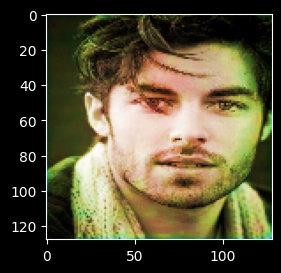

In [61]:
def combine(light, hs_pred):
    light = light * 255
    hs_pred = hs_pred * 255
    print(light.shape, hs_pred.shape)
    res = np.zeros((light.shape[0], light.shape[1], 3), dtype=np.uint8)
    hs_pred = hs_pred.transpose(1, 2, 0)
    res[:, :, 0] = hs_pred[:, :, 0]
    res[:, :, 1] = light
    res[:, :, 2] = hs_pred[:, :, 1]
    return res

combined = combine(X[0, 0].numpy(), model(X[0:1]).detach().numpy()[0])
# plot
plt.subplot(1, 2, 1)
plt.imshow(hls_to_rgb(combined))

(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)
(128, 128) (2, 128, 128)


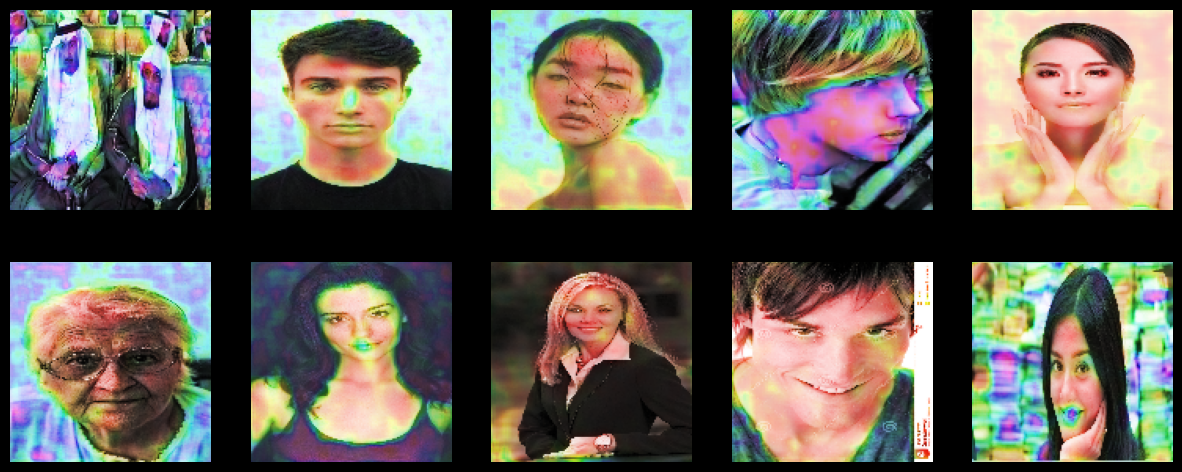

In [88]:
def plot_results(model, X, y, num_images=10):
    idx = np.random.choice(len(X), num_images, replace=False)
    y_pred = model(X[idx]).detach().numpy()
    X_show = X[idx].numpy()

    res_hls = [combine(X_show[i, 0], y_pred[i]) for i in range(num_images)]
    res_rgb = [hls_to_rgb(img) for img in res_hls]
    ncols = min(num_images, 5)
    nrows = (num_images + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))

    for i in range(num_images):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        ax.imshow(res_rgb[i])
        ax.axis('off')

    plt.show()

plot_results(model, X, y)

In [89]:
# save the model
torch.save(model.state_dict(), './../models/color_it.pth')